In [22]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from matplotlib.pylab import rcParams
import statsmodels.tsa.api as smt
rcParams['figure.figsize'] = 8,4

In [49]:
data = pd.read_pickle('C:\\Users\\z0047cfr\\Project Work\\Factory Demand Model\\Input Data\\input_df3.pkl')
# select modelling period
data = data['2015-12-01': '2020-06-01']
#data.tail()

# Checking Stationarity and analysing the series for trend, pattern and remaining Residuals

In [50]:
# Function for the Trend

In [51]:
def trend(a,b):
    sns.set(rc={'figure.figsize':(16, 6)})
    sns.lineplot(x=a,y=b,linewidth=0.8,marker='o',color='green')
    
def trend_fcf(x,y):
    sns.set(rc={'figure.figsize':(16, 6)})
    sns.lineplot(x=x,y=y,linewidth=0.8,marker='o',color='red')

### Welder count trend over time

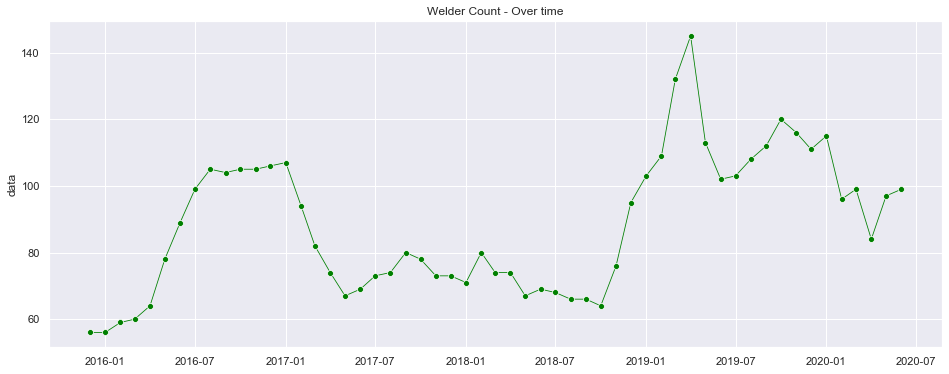

In [69]:
trend(data.index,data.data)
plt.title('Welder Count - Over time');

### Distribution of the Welder count values

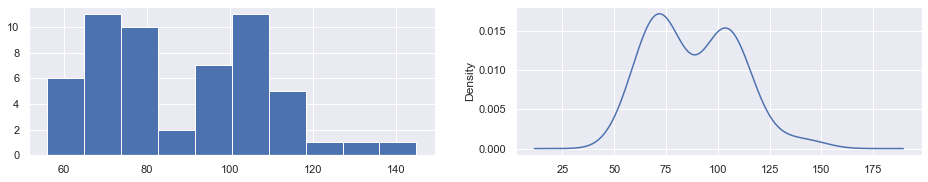

In [53]:
plt.subplot(221)
plt.hist(data.data)
plt.subplot(222)
data['data'].plot(kind = 'kde');

### Checking the assumption of Stationarity 


In [54]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()
    
    #plotting rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    st = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling  Mean & Standard Deviation')
    plt.show()
    
    #Dickey_Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)
    
    if dfoutput[1] <= 0.05:
        print("Data is stationary - and we need no transformation to make it stationary")
    else:
        print(" Data is not stationary and we will need to transform the series to make it stationary ")
    

In [55]:
# Augmented Dickey Fuller Test
def adf(x):
    stationary = adfuller(x,autolag='AIC')
    print('ADF Statistic: %f' % stationary[0])
    print('p-value: %f' % stationary[1])
    print('Critical Values:')
    for key, value in stationary[4].items():
        print('\t%s: %.3f' % (key, value))
    print("What is the Null Hypothesis for ADF :  Data is non -stationary")
    print()

    if stationary[1] > 0.05:
        print("Since p-value = %f, Data is not stationary and we will need to transform the series to make it stationary" %stationary[1])
    else:
        print("Since p-value = %f, Data is stationary - and we need no transformation to make it stationary" %stationary[1])


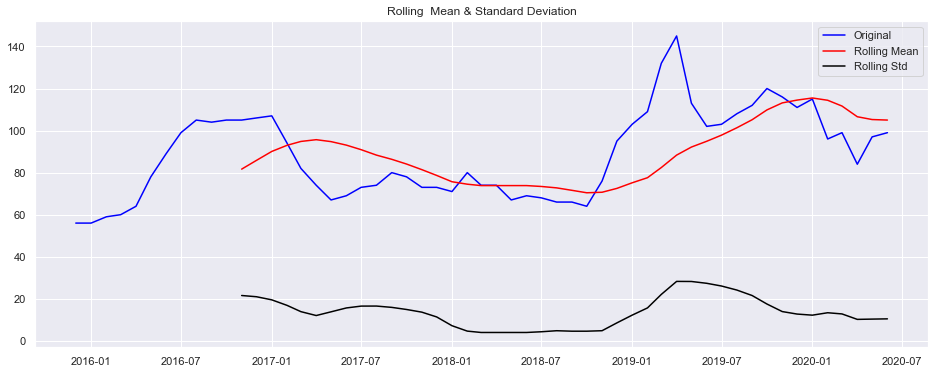

Results of Dickey-Fuller Test:
Test Statistic                 -2.457734
p-value                         0.126100
#Lags Used                      1.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64
 Data is not stationary and we will need to transform the series to make it stationary 


In [56]:
test_stationarity(data.data)

### The trend is not stationary as can be seen from the ADF test and the trend decomposition. We will change the form of trend to try and make it stationary

# 1. Taking the log of Welder Count

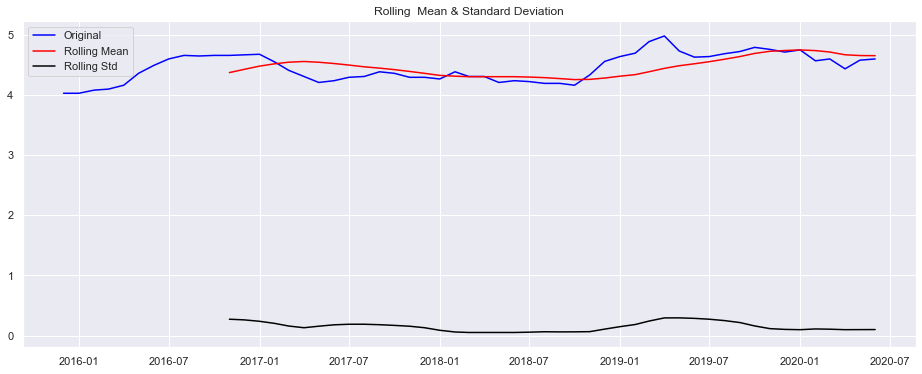

Results of Dickey-Fuller Test:
Test Statistic                 -2.523098
p-value                         0.109955
#Lags Used                      1.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64
 Data is not stationary and we will need to transform the series to make it stationary 
Taking the log did not make the data stationary. we will now try differencing the data to make it stationary


In [57]:
data_log = np.log(data.data)
test_stationarity(data_log)
print('Taking the log did not make the data stationary. we will now try differencing the data to make it stationary')

# 2. Taking first difference of the welder count

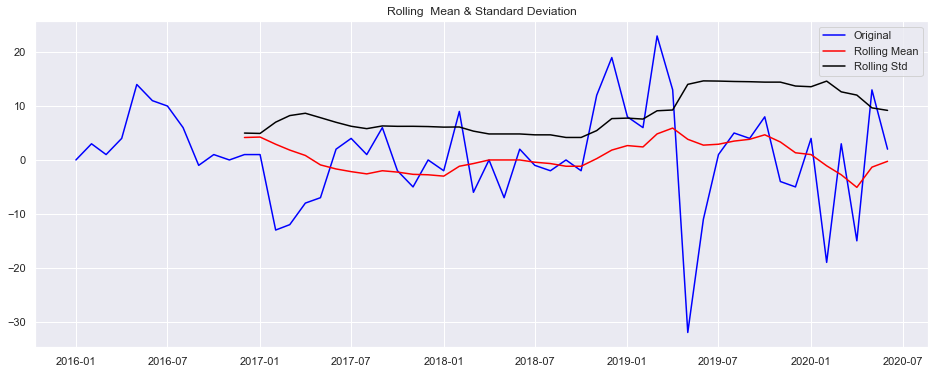

Results of Dickey-Fuller Test:
Test Statistic                -5.698982e+00
p-value                        7.754729e-07
#Lags Used                     0.000000e+00
Number of Observations Used    5.300000e+01
Critical Value (1%)           -3.560242e+00
Critical Value (5%)           -2.917850e+00
Critical Value (10%)          -2.596796e+00
dtype: float64
Data is stationary - and we need no transformation to make it stationary


In [58]:
data['data_diff1'] = ((data['data']) - (data['data'].shift(1))).dropna()
test_stationarity(data['data_diff1'][1:])

In [59]:
def plot_graphs(y,lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax )
        plt.tight_layout()

ADF Statistic: -5.698982
p-value: 0.000001
Critical Values:
	1%: -3.560
	5%: -2.918
	10%: -2.597
What is the Null Hypothesis for ADF :  Data is non -stationary

Since p-value = 0.000001, Data is stationary - and we need no transformation to make it stationary


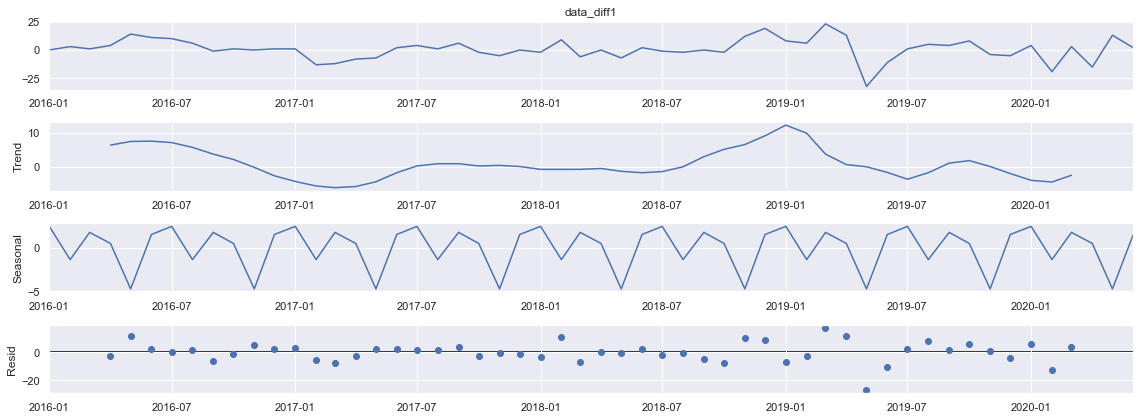

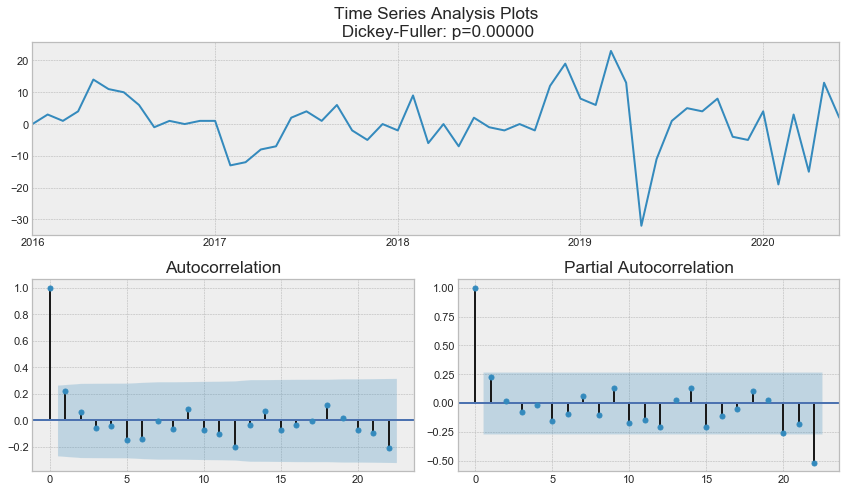

In [60]:
sm.tsa.seasonal_decompose(data['data_diff1'][1:],freq=6).plot()
plot_graphs(data['data_diff1'][1:],lags=22)
adf(data['data_diff1'][1:])

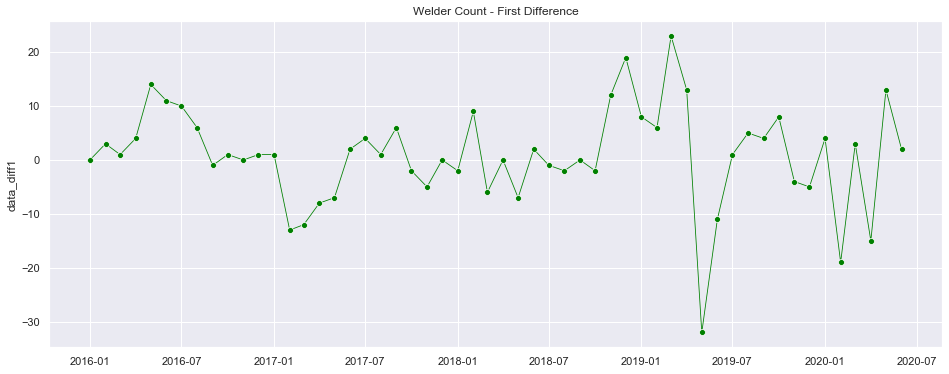

In [68]:
trend(data.index,data['data_diff1'])
plt.title('Welder Count - First Difference');

### The first difference does make the trend stationary. It can also be seen that the decomposed trend doesnt have any trend component left.  Lets take the second difference to ensure trend behavior to ensure if second difference can be used too in the modelling iterations

# 3. Taking Second difference of the data

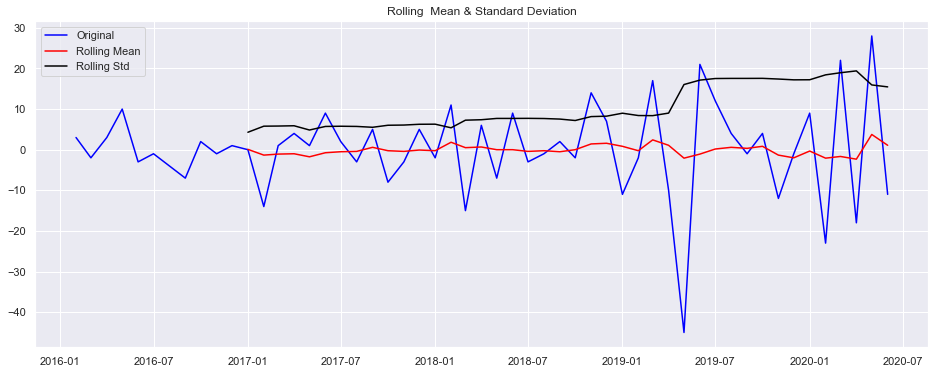

Results of Dickey-Fuller Test:
Test Statistic                -6.173884e+00
p-value                        6.702968e-08
#Lags Used                     2.000000e+00
Number of Observations Used    5.000000e+01
Critical Value (1%)           -3.568486e+00
Critical Value (5%)           -2.921360e+00
Critical Value (10%)          -2.598662e+00
dtype: float64
Data is stationary - and we need no transformation to make it stationary


In [62]:
data['data_diff2_1'] = ((data['data']) - 2*(data['data'].shift(1)) + data['data'].shift(2)).dropna()
# second difference = first difference of y - first difference of yt-1
#(yt - yt-1) - (yt-1 - yt-2)
#yt − 2 yt−1 + yt−2
#https://otexts.com/fpp2/stationarity.html
test_stationarity(data['data_diff2_1'][2:])

# Second difference of the data is stationary series too. Lets decompose the series to look at trend pattern and residuals

ADF Statistic: -6.173884
p-value: 0.000000
Critical Values:
	1%: -3.568
	5%: -2.921
	10%: -2.599
What is the Null Hypothesis for ADF :  Data is non -stationary

Since p-value = 0.000000, Data is stationary - and we need no transformation to make it stationary


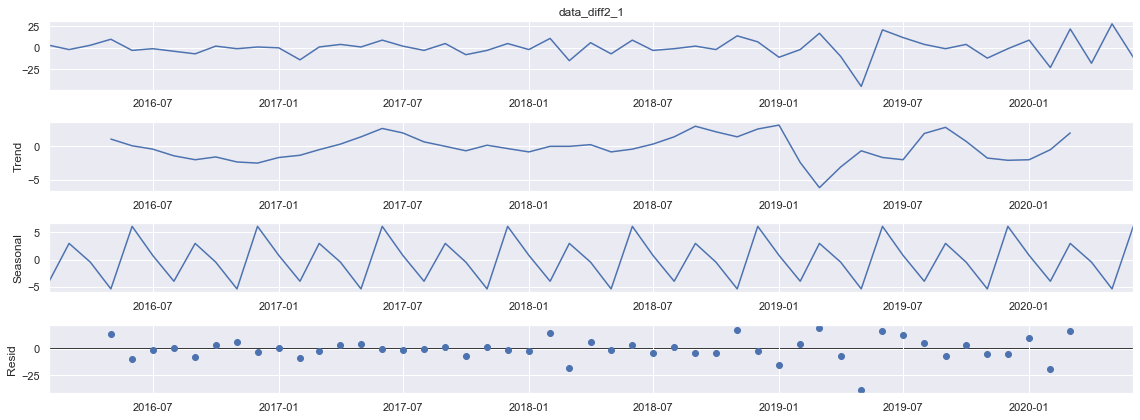

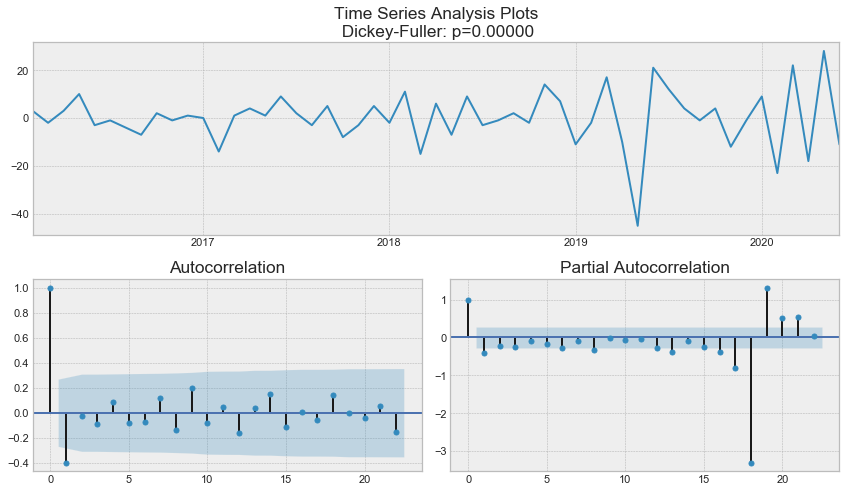

In [63]:
sm.tsa.seasonal_decompose(data['data_diff2_1'][2:],freq=6).plot()
plot_graphs(data['data_diff2_1'][2:],lags=22)
adf(data['data_diff2_1'][2:])

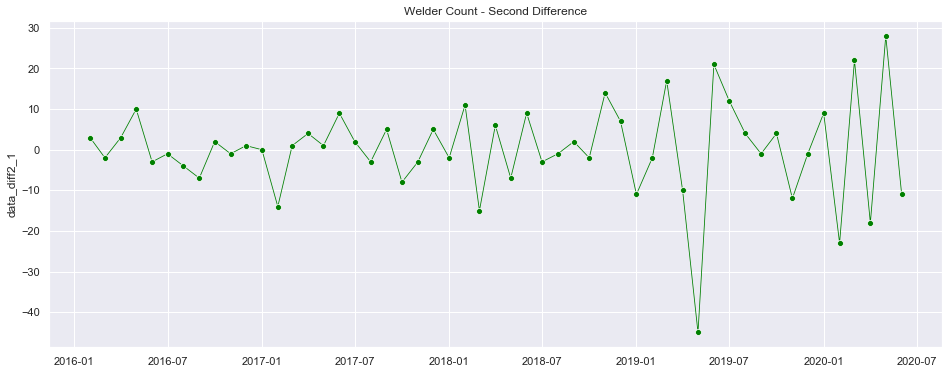

In [67]:
trend(data.index,data['data_diff2_1'])
plt.title('Welder Count - Second Difference');

# Looking at decomposition of differenced trends, we see no trend at both first and second difference but we do see minor seasonality

In [1]:
import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)

ToggleButton(value=False, description='Show code')